### features:
* time domain features
* statistical features
* all zero crossing rate coef
* no tempogram values
* no wavelet
* fractal analysis


In [3]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

In [4]:
path =  "/Users/ecem/Desktop/phonocardiogram/data"

In [7]:
AV_path =  "/Users/ecem/Desktop/phonocardiogram/data/AV"
MV_path =  "/Users/ecem/Desktop/phonocardiogram/data/MV"
PV_path =  "/Users/ecem/Desktop/phonocardiogram/data/PV"
TV_path =  "/Users/ecem/Desktop/phonocardiogram/data/TV"

## Load data

In [5]:
time_domain_features = pd.read_csv(path + "/time-domain-features.csv", index_col = 0)
statistical_features = pd.read_csv(path + "/statistical-features.csv", index_col = 0)
fractal_features = pd.read_csv(path + "/mock-features.csv", index_col = 0)

In [8]:
p_zcrs_av = pd.DataFrame(np.load(AV_path + "/present/present_AV_zcrs_array.npy", allow_pickle = True))
p_zcrs_mv = pd.DataFrame(np.load(MV_path + "/present/present_MV_zcrs_array.npy", allow_pickle = True))
p_zcrs_pv = pd.DataFrame(np.load(PV_path + "/present/present_PV_zcrs_array.npy", allow_pickle = True))
p_zcrs_tv = pd.DataFrame(np.load(TV_path + "/present/present_TV_zcrs_array.npy", allow_pickle = True))


zcrs = pd.concat([p_zcrs_av, p_zcrs_mv, p_zcrs_pv, p_zcrs_tv], axis = 0 )
zcrs.shape

(4728, 5)

In [4]:
time_domain_features.head()

,energy,entropy,spectral entropy,spectral rolloff,spectral centorid
0,0.003627,1.669286,0.188441,0.07420,0.053309
1,0.000750,2.963927,0.043663,0.04800,0.042804
2,0.000388,2.840991,0.017348,0.04395,0.034369
3,0.000528,2.859511,0.025138,0.04730,0.037526
4,0.000721,2.733358,0.029182,0.04545,0.041871


In [5]:
statistical_features.head()

,mean,std,skewness,kurtosis,harmonic mean,ac peak height mean
0,-0.000040,0.060224,-0.638895,51.817342,4.405790e-10,2.167401
1,-0.000483,0.027385,0.169739,2.901926,1.058298e-08,0.825860
2,-0.000067,0.019704,0.181507,4.582113,2.210099e-09,0.303073
3,-0.000062,0.022971,-0.092871,3.136028,4.928371e-09,0.467023
4,0.000141,0.026843,0.031420,4.079496,1.251589e-11,0.599395


In [6]:
fractal_features.head()

,petrosian f.a.,katz f.a.,higuchi f.a.,deterended fluctuations f.a.
0,1.002736,1.920990,1.091685,0.921825
1,1.002308,2.377508,1.052431,0.904970
2,1.002273,2.223252,1.046259,0.982775
3,1.002218,2.291023,1.048935,0.942318
4,1.002254,2.274571,1.046809,0.918872


In [9]:
features = pd.concat([statistical_features, time_domain_features, fractal_features, zcrs], axis = 1)
features.head()

,mean,std,skewness,kurtosis,harmonic mean,ac peak height mean,energy,entropy,spectral entropy,spectral rolloff,spectral centorid,petrosian f.a.,katz f.a.,higuchi f.a.,deterended fluctuations f.a.,0,1,2,3,4
0,-0.000040,0.060224,-0.638895,51.817342,4.405790e-10,2.167401,0.003627,1.669286,0.188441,0.07420,0.053309,1.002736,1.920990,1.091685,0.921825,0.013000,0.036000,0.035750,0.034875,1399.0
1,-0.000483,0.027385,0.169739,2.901926,1.058298e-08,0.825860,0.000750,2.963927,0.043663,0.04800,0.042804,1.002308,2.377508,1.052431,0.904970,0.018250,0.031000,0.039125,0.026000,1394.0
2,-0.000067,0.019704,0.181507,4.582113,2.210099e-09,0.303073,0.000388,2.840991,0.017348,0.04395,0.034369,1.002273,2.223252,1.046259,0.982775,0.019125,0.035625,0.030750,0.031500,1300.0
3,-0.000062,0.022971,-0.092871,3.136028,4.928371e-09,0.467023,0.000528,2.859511,0.025138,0.04730,0.037526,1.002218,2.291023,1.048935,0.942318,0.015125,0.036625,0.031125,0.032000,1299.0
4,0.000141,0.026843,0.031420,4.079496,1.251589e-11,0.599395,0.000721,2.733358,0.029182,0.04545,0.041871,1.002254,2.274571,1.046809,0.918872,0.017625,0.028625,0.039500,0.034000,1344.0


## Load labels

In [10]:
labels = np.load(path + "/labels.npy", allow_pickle = True)

In [11]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features, labels, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [12]:
import xgboost as xgb
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf = Pipeline([('classify', classifier)])


In [13]:
clf.fit(X_train_, y_train_)


Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

In [14]:
yhat = clf.predict(X_valid_)

In [15]:
df_results_test = pd.DataFrame({'AV': y_valid_[:,0], 'MV': y_valid_[:,1], 'PV': y_valid_[:,2], 'TV': y_valid_[:,3],
                        'predicted AV': yhat[:,0],
                          'predicted MV': yhat[:,1],
                          'predicted PV': yhat[:,2], 
                          'predicted TV': yhat[:,3]})
df_results_test

,AV,MV,PV,TV,predicted AV,predicted MV,predicted PV,predicted TV
0,0.0,0.0,0.0,1.0,0,0,0,0
1,0.0,0.0,1.0,0.0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,1,0,0
3,0.0,0.0,1.0,0.0,0,0,0,0
4,0.0,1.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
941,1.0,0.0,0.0,0.0,0,0,0,0
942,0.0,0.0,1.0,0.0,0,0,1,0
943,0.0,1.0,0.0,0.0,0,0,0,0
944,1.0,0.0,0.0,0.0,1,0,0,0


In [16]:
auc_y1 = roc_auc_score(y_valid_[:,0],yhat[:,0])
auc_y2 = roc_auc_score(y_valid_[:,1],yhat[:,1])
auc_y3 = roc_auc_score(y_valid_[:,2],yhat[:,2])
auc_y4 = roc_auc_score(y_valid_[:,3],yhat[:,3])

print("ROC AUC AV: %.4f, MV: %.4f, PV: %.4f, TV: %.4f " % (auc_y1, auc_y2, auc_y3, auc_y4))


ROC AUC AV: 0.6620, MV: 0.6178, PV: 0.6944, TV: 0.6918 


In [17]:
weighted_roc_auc_ovo = roc_auc_score(
    y_valid_, yhat, multi_class="ovr", average="weighted"
)

In [18]:
weighted_roc_auc_ovo

0.6677965269930659

In [19]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


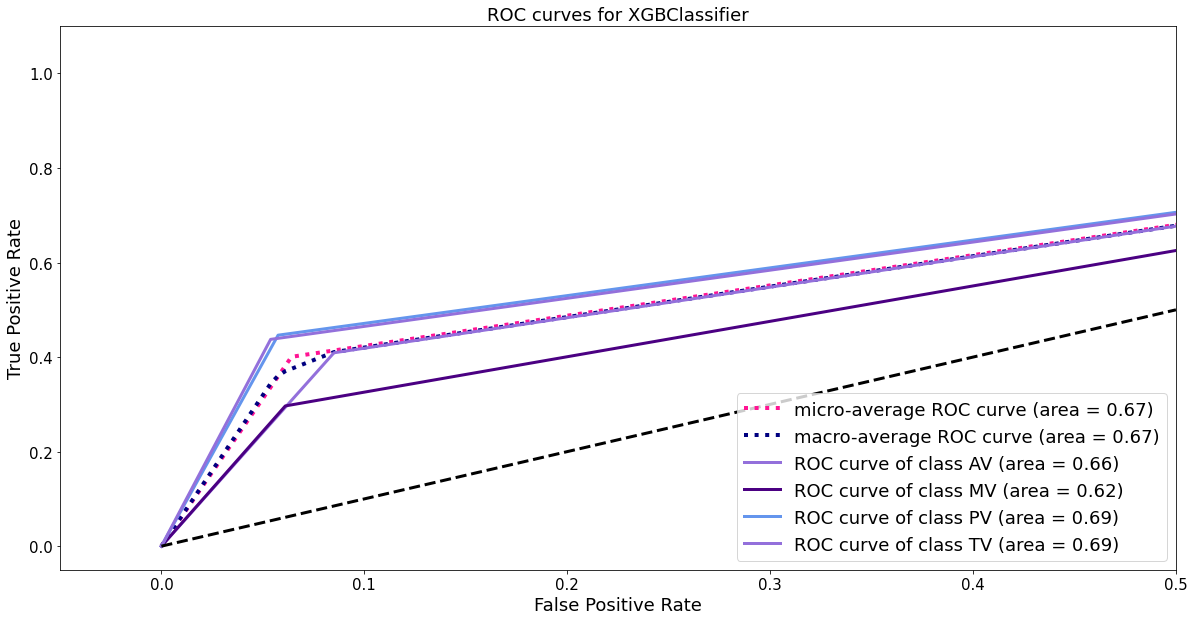

In [20]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AV", "MV", "PV", "TV"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate",fontsize = 18 )
plt.ylabel("True Positive Rate", fontsize = 18)
plt.title("ROC curves for XGBClassifier",fontsize = 18)
plt.legend(loc="lower right", fontsize = 18) 
plt.show()

In [21]:
cm_y1 = confusion_matrix(y_valid_[:,0],yhat[:,0])
cm_y2 = confusion_matrix(y_valid_[:,1],yhat[:,1])
cm_y3 = confusion_matrix(y_valid_[:,2],yhat[:,2])
cm_y4 = confusion_matrix(y_valid_[:,3],yhat[:,3])
print(cm_y1)



[[624  58]
 [156 108]]


In [22]:
class_dict = {0:'AV', 1:'MV', 2:'PV', 3:'TV'}

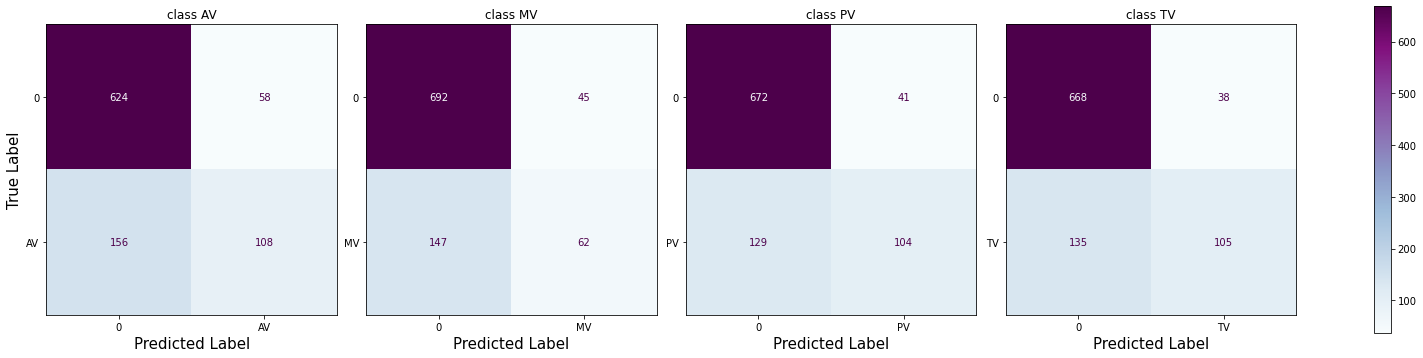

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(1, 4, figsize=(28, 15))
axes = axes.ravel()
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_valid_[:, i],
                                                   yhat[:, i]),
                                  display_labels=[0, i])
    if i == 0:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel('True Label', fontsize = 15)
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
    else:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel(' ')
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
        

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink= 0.4)
plt.show()

In [24]:
cm_y2

array([[692,  45],
       [147,  62]])

In [25]:
cm_y3

array([[672,  41],
       [129, 104]])

In [26]:
cm_y4

array([[668,  38],
       [135, 105]])

In [27]:
cr_y1 = classification_report(y_valid_[:,0],yhat[:,0]) # AR
cr_y2 = classification_report(y_valid_[:,1],yhat[:,1]) # AS
cr_y3 = classification_report(y_valid_[:,2],yhat[:,2]) # MR
cr_y4 = classification_report(y_valid_[:,3],yhat[:,3]) # MS

print (cr_y1)
print (cr_y2)
print (cr_y3)
print (cr_y4)




              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       682
         1.0       0.65      0.41      0.50       264

    accuracy                           0.77       946
   macro avg       0.73      0.66      0.68       946
weighted avg       0.76      0.77      0.76       946

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88       737
         1.0       0.58      0.30      0.39       209

    accuracy                           0.80       946
   macro avg       0.70      0.62      0.64       946
weighted avg       0.77      0.80      0.77       946

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       713
         1.0       0.72      0.45      0.55       233

    accuracy                           0.82       946
   macro avg       0.78      0.69      0.72       946
weighted avg       0.81      0.82      0.80       946

              preci

## With threshold

In [28]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =  0.0001)   # düşük  threshold
_ = vt.fit(features)
masked = vt.get_support()
features_masked = features.loc[:, masked]
features_masked # uncomment to see the dataframe

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,std,skewness,kurtosis,ac peak height mean,energy,entropy,spectral entropy,spectral rolloff,spectral centorid,katz f.a.,higuchi f.a.,deterended fluctuations f.a.,1,2,3,4
0,0.060224,-0.638895,51.817342,2.167401,0.003627,1.669286,0.188441,0.07420,0.053309,1.920990,1.091685,0.921825,0.036000,0.035750,0.034875,1399.0
1,0.027385,0.169739,2.901926,0.825860,0.000750,2.963927,0.043663,0.04800,0.042804,2.377508,1.052431,0.904970,0.031000,0.039125,0.026000,1394.0
2,0.019704,0.181507,4.582113,0.303073,0.000388,2.840991,0.017348,0.04395,0.034369,2.223252,1.046259,0.982775,0.035625,0.030750,0.031500,1300.0
3,0.022971,-0.092871,3.136028,0.467023,0.000528,2.859511,0.025138,0.04730,0.037526,2.291023,1.048935,0.942318,0.036625,0.031125,0.032000,1299.0
4,0.026843,0.031420,4.079496,0.599395,0.000721,2.733358,0.029182,0.04545,0.041871,2.274571,1.046809,0.918872,0.028625,0.039500,0.034000,1344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,0.222230,0.235907,3.293451,94.429661,0.049386,2.913031,0.003455,0.01245,0.022283,1.917979,1.016475,1.278429,0.009125,0.008625,0.009375,382.0
1201,0.191557,0.023518,4.545471,69.914666,0.036694,2.950586,0.004319,0.01265,0.023515,1.853328,1.022238,1.283995,0.008500,0.009250,0.009625,388.0
1202,0.214602,0.145022,4.014102,100.846936,0.046054,3.018884,0.004654,0.01095,0.039226,1.901451,1.022018,1.306491,0.009375,0.007500,0.008125,358.0
1203,0.190516,0.021085,3.707966,71.007218,0.036297,2.993076,0.014952,0.01215,0.045749,1.815818,1.054990,1.273177,0.009000,0.010000,0.012750,456.0


In [29]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, labels, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [30]:
import xgboost as xgb
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf = Pipeline([('classify', classifier)])

In [31]:
clf.fit(X_train_, y_train_)


Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

In [32]:
yhat = clf.predict(X_valid_)

In [33]:
df_results_test = pd.DataFrame({'AV': y_valid_[:,0], 'MV': y_valid_[:,1], 'PV': y_valid_[:,2], 'TV': y_valid_[:,3],
                        'predicted AV': yhat[:,0],
                          'predicted MV': yhat[:,1],
                          'predicted PV': yhat[:,2], 
                          'predicted TV': yhat[:,3]})
df_results_test

,AV,MV,PV,TV,predicted AV,predicted MV,predicted PV,predicted TV
0,0.0,0.0,0.0,1.0,0,0,0,0
1,0.0,0.0,1.0,0.0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,1,0,0
3,0.0,0.0,1.0,0.0,0,0,0,0
4,0.0,1.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
941,1.0,0.0,0.0,0.0,0,0,0,0
942,0.0,0.0,1.0,0.0,0,0,1,0
943,0.0,1.0,0.0,0.0,0,0,0,0
944,1.0,0.0,0.0,0.0,1,0,0,0


In [34]:
auc_y1 = roc_auc_score(y_valid_[:,0],yhat[:,0])
auc_y2 = roc_auc_score(y_valid_[:,1],yhat[:,1])
auc_y3 = roc_auc_score(y_valid_[:,2],yhat[:,2])
auc_y4 = roc_auc_score(y_valid_[:,3],yhat[:,3])

print("ROC AUC AV: %.4f, MV: %.4f, PV: %.4f, TV: %.4f " % (auc_y1, auc_y2, auc_y3, auc_y4))

ROC AUC AV: 0.6593, MV: 0.6102, PV: 0.6960, TV: 0.6723 


In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

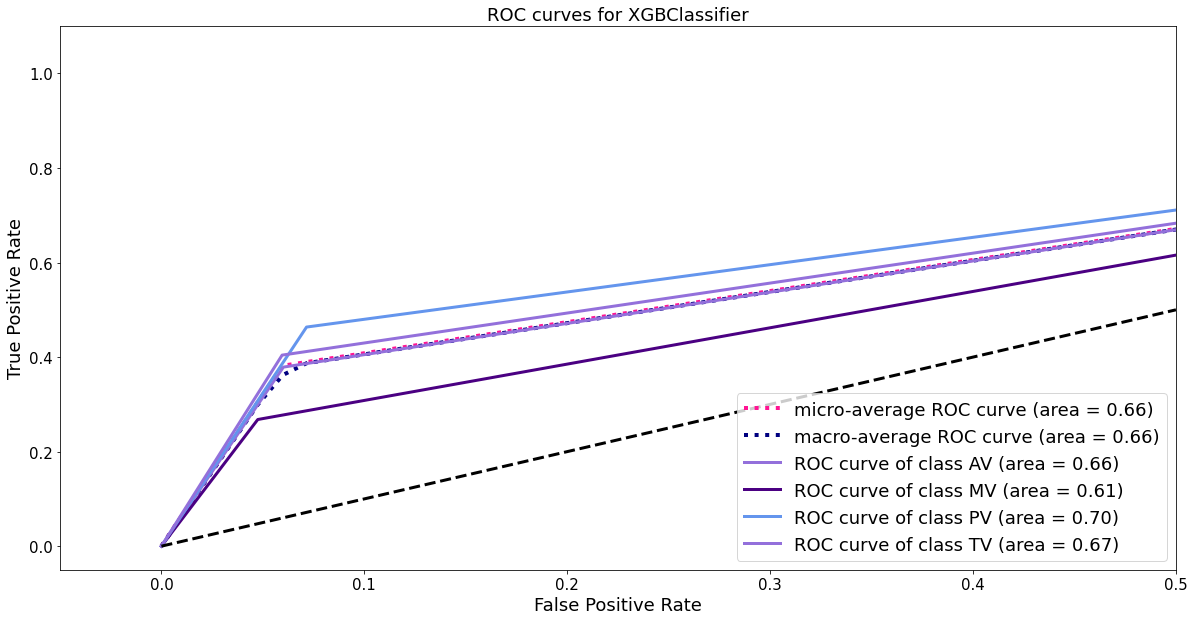

In [36]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AV", "MV", "PV", "TV"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate",fontsize = 18 )
plt.ylabel("True Positive Rate", fontsize = 18)
plt.title("ROC curves for XGBClassifier",fontsize = 18)
plt.legend(loc="lower right", fontsize = 18) 
plt.show()

In [37]:
cr_y1 = classification_report(y_valid_[:,0],yhat[:,0]) # AR
cr_y2 = classification_report(y_valid_[:,1],yhat[:,1]) # AS
cr_y3 = classification_report(y_valid_[:,2],yhat[:,2]) # MR
cr_y4 = classification_report(y_valid_[:,3],yhat[:,3]) # MS

print (cr_y1)
print (cr_y2)
print (cr_y3)
print (cr_y4)

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86       682
         1.0       0.71      0.38      0.49       264

    accuracy                           0.78       946
   macro avg       0.75      0.66      0.68       946
weighted avg       0.77      0.78      0.76       946

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       737
         1.0       0.62      0.27      0.37       209

    accuracy                           0.80       946
   macro avg       0.72      0.61      0.63       946
weighted avg       0.78      0.80      0.77       946

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88       713
         1.0       0.68      0.46      0.55       233

    accuracy                           0.81       946
   macro avg       0.76      0.70      0.72       946
weighted avg       0.80      0.81      0.80       946

              preci